In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
import os
import tifffile as tf
from scipy import ndimage, stats
import utils
import math

from sklearn import cluster

def divisors(n):
    divs = [1]
    for i in range(2,int(math.sqrt(n))+1):
        if n%i == 0:
            divs.extend([i,n//i])
    divs.extend([n])
    return sorted(list(set(divs)))

In [2]:
fsrc = '../Bacteria Info for Erik/'
csrc = '../data/'
wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
ksrc = '../kde/'
sample = 'D2'
marker = ['D', '8', 's', '^', 'v', 'P', 'X', '*']
color = ['#c44601', '#054fb9', '#5ba300', '#8babf1', '#e6308a', '#5928ed']
cmap = ['Blues_r', 'Greens_r', 'BuPu_r', 'Oranges_r', 'RdPu_r', 'YlOrBr_r', 'gray', 'gist_gray', 'Wistia']
fs = 15
rng = np.random.default_rng(42)
pxs = 75
pxbar = np.s_[-15:-5, 5:5 + pxs]

wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))

ksrc += sample + os.sep

dst = fsrc

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col = 0)
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv')
tcumsum = np.hstack(([0], np.cumsum(metatrans['cyto_number'].values)))
transcriptomes = np.asarray(metatrans['gene'])

Cells = pd.read_excel(fsrc + 'Infected Cells w. Nuc.xlsx').values.squeeze()
cells = np.zeros_like(Cells)
for i in range(len(Cells)):
    cells[i] = metacell[metacell['orig_cellID'] == Cells[i]].index[0]

nuccutoff = 1
voronoi = tf.imread(nsrc + sample + '_EDT.tif')
nuclei = voronoi < nuccutoff

lnuc, nnuc = ndimage.label(nuclei, ndimage.generate_binary_structure(2,1))
nuc_area, _ = np.histogram(lnuc, bins=np.arange(nnuc + 2))
nuc_area[0] = 0 #ignore the non-nuclear area
print('Detected',nnuc,'nuclei')

wall[nuclei] = False
wcoords = np.asarray(np.nonzero(~wall))
wallshape = wall.shape
wc = wcoords[:, ~np.all(wcoords%100, axis=0)]

cell_nucs = [ np.empty((0,2)) for _ in range(len(metacell))]

for i in range(len(cell_nucs)):
    cidx = metacell.iloc[i].name
    if metacell.loc[cidx, 'nuclei_area'] > 0:
        cidx = metacell.iloc[i].name
        cell, cextent = utils.get_cell_img(cidx, metacell, wall, label, pxbar=False)
        s_= np.s_[cextent[2]:cextent[3], cextent[0]:cextent[1]]

        uq, ct = np.unique(lnuc[s_][(lnuc[s_] > 0) & (label[s_] == cidx)], return_counts=True)
        cell_nucs[i] = np.vstack((uq,ct))

filename = csrc + sample + '_data/32771-slide1_' + sample + '_results.txt'
tlocs = pd.read_csv(filename, header=None, sep='\t').drop(columns=[4])
tlocs.columns = ['X', 'Y', 'Z', 'T']

transcriptomes, invidx, tsize = np.unique(tlocs.loc[:,'T'], return_index = False, return_inverse=True, return_counts=True) 
tlocs = tlocs.loc[:, ['X','Y','Z']]
tlocs['L'] = 'c'
print('\nFound data for', len(transcriptomes), 'transcriptomes')

translocs = [None for i in range(len(transcriptomes))]
for tidx in range(len(transcriptomes)):
    translocs[tidx] = tlocs.loc[invidx == tidx]

zmax = tlocs['Z'].max()
zmin = tlocs['Z'].min()
Ns = divisors(zmax-zmin)[:-2]

zcells = dict()

for tidx in range(len(transcriptomes)):
    
    zcells[transcriptomes[tidx]] = dict()
    nuct = translocs[tidx].loc[ nuclei[ translocs[tidx]['Y'], translocs[tidx]['X'] ] ]
    
    for i in range(len(metacell)):
    
        cidx = metacell.iloc[i].name
        if len(cell_nucs[i]) > 0:
            
            zcells[transcriptomes[tidx]][cidx] = dict()
            
            for j in range(len(cell_nucs[i][0])):
                nz = nuct.loc[ (label[ nuct['Y'], nuct['X'] ] == cidx) & (lnuc[ nuct['Y'], nuct['X'] ] == cell_nucs[i][0,j]), 'Z']
                zcells[transcriptomes[tidx]][cidx][cell_nucs[i][0,j]] = nz.values
                

bins = np.arange(zmin, zmax+1, Ns[2])
hparams = {'bins':bins, 'alpha':0.35, 'density':True, 'orientation':'horizontal', 'zorder':2}

tbac = pd.concat(translocs[:10], ignore_index=True)

nuct = tbac.loc[ nuclei[ tbac['Y'], tbac['X'] ] ]
cytt = tbac.loc[~nuclei[ tbac['Y'], tbac['X'] ] ]

print(nuct.shape, cytt.shape)

Detected 1365 nuclei

Found data for 97 transcriptomes
(24596, 4) (1963314, 4)


In [3]:
metacell.loc[np.intersect1d(metacell[metacell['number_nuclei'] > 1].index, cells), 'orig_cellID'].values

array([ 150,  216,  268,  343,  360,  405,  421,  422,  444,  464,  524,
        528,  576,  645,  646,  747,  791,  840,  917,  922,  983,  994,
       1049, 1070, 1121, 1125, 1150, 1187, 1215, 1216, 1367, 1380, 1390,
       1507, 1506, 1522, 1546, 1561, 1575, 1711, 1718, 1726, 1839, 1999,
       2007, 2145, 2150, 2308, 2404])

In [182]:
i = 1866

NX,NY,NZ = [],[],[]

cidx = metacell.iloc[i].name
cell, cextent = utils.get_cell_img(cidx, metacell, wall, label, pxbar=True)
s_= np.s_[cextent[2]:cextent[3], cextent[0]:cextent[1]]

Nx,Ny,Nz = nuct.loc[label[ nuct['Y'], nuct['X'] ] == cidx, ['X','Y','Z']].values.T
cx,cy,cz = cytt.loc[label[ cytt['Y'], cytt['X'] ] == cidx, ['X','Y','Z']].values.T


perc_nuc_inside = cell_nucs[i][1]/nuc_area[cell_nucs[i][0]]

for k in range(len(perc_nuc_inside)):
    nx,ny,nz = nuct.loc[label[ nuct['Y'], nuct['X'] ] == cidx].loc[lnuc[ Ny, Nx ] == cell_nucs[i][0,k], ['X','Y','Z']].values.T
    NX.append(nx); NY.append(ny); NZ.append(nz); 

print(cidx, Nz.shape, nz.shape, cz.shape, len(nz) + len(cz) )

1867 (94,) (94,) (3598,) 3692


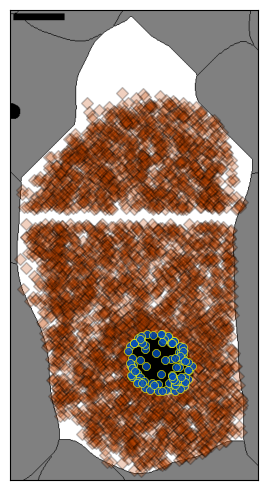

In [194]:
fig, ax = plt.subplots( 1,1, figsize=(5, 5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j = 0

ax[j].imshow(cell, cmap='binary_r', origin='lower', extent=cextent, vmin=0, vmax=2, zorder=1);
ax[j].scatter(cx,cy, c=color[0], marker=marker[0], edgecolor='k', alpha=0.25, zorder=2)
for k in range(len(NZ)):
    ax[j].scatter(NX[k],NY[k], c=color[k+1], marker=marker[k+1], edgecolor='yellow', alpha=0.8, zorder=3, linewidth=0.5)
ax[j].set_facecolor('#808080')

for j in range(len(ax)):
    ax[j].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

fig.tight_layout();

KstestResult(statistic=0.0005558643690939411, pvalue=0.9995841748540955, statistic_location=14, statistic_sign=-1)
KstestResult(statistic=0.4775222345747638, pvalue=2.5402955047625875e-13, statistic_location=20, statistic_sign=1)
--
KstestResult(statistic=0.8982768204558088, pvalue=9.027398134238627e-20, statistic_location=30, statistic_sign=-1)
KstestResult(statistic=0.0, pvalue=1.0, statistic_location=42, statistic_sign=1)
--


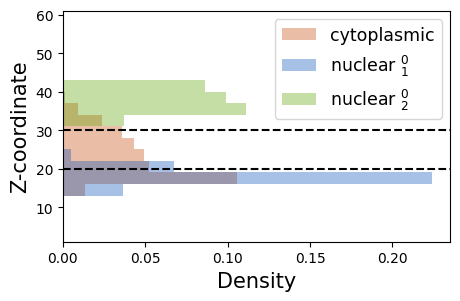

In [63]:
fs = 15
fig, ax = plt.subplots( 1,1, figsize=(5,3), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); j = 0

h = ax[j].hist(cz, color=color[0], label='cytoplasmic', **hparams)
for k in range(len(NZ)):
    if len(NZ[k]) > 4:
        dbscan = cluster.DBSCAN(eps=2.5, min_samples=5, n_jobs=1).fit_predict(NZ[k].reshape(-1,1))
        uq = np.unique(dbscan)
        for i in uq[uq > -1]:
            nz = NZ[k][dbscan == i]
            h = ax[j].hist(nz, color=color[3*k + i+1], label='nuclear $_{}^{}$'.format(i+1, k), **hparams)
            
            ksless = stats.ks_2samp(nz,cz,'less', method='asymp')
            ksgreater = stats.ks_2samp(nz,cz,'greater', method='asymp')
            print(ksless, ksgreater, '--', sep='\n')
            for ks in [ksless, ksgreater]:
                if ks.pvalue < 1e-2:
                    ax[j].axhline(ks.statistic_location, c='k', ls='--', zorder=3)

ax[j].set_xlabel('Density', fontsize=fs)
ax[j].set_ylabel('Z-coordinate', fontsize=fs)
ax[j].set_ylim(zmin,zmax)
ax[j].legend(fontsize=12.5, loc='upper right');

#plt.savefig(dst + 'foo.jpg', bbox_inches='tight')

In [25]:
bins = np.arange(zmin, zmax+1, Ns[2])
hparams = {'bins':bins, 'alpha':0.35, 'density':True, 'orientation':'horizontal', 'zorder':2}

tbac = pd.concat(translocs[:10], ignore_index=True)
nuct = tbac.loc[ nuclei[ tbac['Y'], tbac['X'] ] ]
cytt = tbac.loc[~nuclei[ tbac['Y'], tbac['X'] ] ]

filename = dst + 'BAC_nuclear_localization_estimates.csv'

if not os.path.isfile(filename):

    columns = ['ndimage_ID', 'nuc_ID', 'perc_inside', 'N_inside', 
               'dbscan', 'nz_min', 'nz_max',
               'pval_up', 'lim_up', 'pval_down', 'lim_down']
    dfastype = {'ndimage_ID':int, 'nuc_ID':int, 'N_inside':int, 'lim_up':int, 'lim_down':int, 'nz_min':int, 'nz_max':int, 'dbscan':int}
    
    nuc_lims = []
    
    for i in range(len(metacell)):
        
        cidx = metacell.iloc[i].name
            
        if (len(cell_nucs[i]) > 0):
        
            cell, cextent = utils.get_cell_img(cidx, metacell, wall, label, pxbar=False)
            s_= np.s_[ cextent[2]:cextent[3], cextent[0]:cextent[1] ]
                
            Nx,Ny,Nz = nuct.loc[label[ nuct['Y'], nuct['X'] ] == cidx, ['X','Y','Z']].values.T
            cx,cy,cz = cytt.loc[label[ cytt['Y'], cytt['X'] ] == cidx, ['X','Y','Z']].values.T
        
            perc_nuc_inside = cell_nucs[i][1]/nuc_area[cell_nucs[i][0]]
            
            for k in range(len(perc_nuc_inside)):
                
                nx,ny,nz = nuct.loc[label[ nuct['Y'], nuct['X'] ] == cidx].loc[lnuc[ Ny, Nx ] == cell_nucs[i][0,k], ['X','Y','Z']].values.T
                
                if (len(nz) > 2) & (len(cz) > 2):
    
                    dbscan = cluster.DBSCAN(eps=2.5, min_samples=5, n_jobs=1).fit_predict(nz.reshape(-1,1))
                    uq = np.unique(dbscan)
                    
                    for j in uq: 
    
                        z = nz[dbscan == j]
                        
                        ksless = stats.ks_2samp(z, cz,'less', method='asymp')
                        ksgreater = stats.ks_2samp(z, cz,'greater', method='asymp')
                        
                        foo = [cidx, cell_nucs[i][0,k], perc_nuc_inside[k], len(z),
                               j, z.min(), z.max(), 
                               ksless.pvalue, ksless.statistic_location, 
                               ksgreater.pvalue, ksgreater.statistic_location]
                
                        nuc_lims.append(foo)

                else:
                    
                    foo = [cidx, cell_nucs[i][0,k], perc_nuc_inside[k], len(nz), -1, zmin, zmax, 2,0,2,0 ]
                    nuc_lims.append(foo)
    
    
    nuc_lims = np.array(nuc_lims)
    df = pd.DataFrame(nuc_lims, columns=columns).astype(dfastype)
    df.to_csv(filename, index=False)

bacs = pd.read_csv(filename)
print(bacs.shape)
bacs.head()

(2065, 11)


,ndimage_ID,nuc_ID,perc_inside,N_inside,dbscan,nz_min,nz_max,pval_up,lim_up,pval_down,lim_down
0,1,1,0.011579,0,-1,1,61,2.0,0,2.0,0
1,1,3,1.000000,0,-1,1,61,2.0,0,2.0,0
2,1,4,0.431034,0,-1,1,61,2.0,0,2.0,0
3,1,9,1.000000,0,-1,1,61,2.0,0,2.0,0
4,1,15,1.000000,0,-1,1,61,2.0,0,2.0,0


# Load all data and go thru the rest of genes

In [96]:
foo = metacell.iloc[ np.nonzero(np.array(list(map(len, cell_nucs))) > 1)[0] ]
print('There are', len(foo), 'cells with some nuclear pixels')
print('There are', len(np.intersect1d(foo[foo['number_nuclei'] <= 1].index.values, cells)), 'infected cells with no more than 1 nucleus')

focus = np.intersect1d(cells, metacell[metacell['number_nuclei'] <= 1].index)
print(np.sum(focus == np.intersect1d(foo[foo['number_nuclei'] <= 1].index.values, cells)))

There are 1316 cells with some nuclear pixels
There are 370 infected cells with no more than 1 nucleus
370


In [155]:
pvaltol = 1e-2
pvaldirs = ['pval_up', 'pval_down']

cell_nuc = bacs.loc[:, ['ndimage_ID','nuc_ID', 'perc_inside']].drop_duplicates()

N_bot = np.zeros(len(cell_nuc), dtype = int); N_top = N_bot.copy()
P_top = np.zeros(len(cell_nuc)); P_bot = P_top.copy()
N_inside = N_bot.copy()

for i in range(len(cell_nuc)):
    n_bot, n_top = zmin, zmax
    p_bot, p_top = 0,0
    cidx, nidx = cell_nuc.iloc[i, :2].values
    
    nuc_lims = bacs[ (bacs['ndimage_ID'] == cidx) & (bacs['nuc_ID'] == nidx) ]
    flag = (nuc_lims['dbscan'] != -1) & (nuc_lims['N_inside'] > 2) & ((nuc_lims['pval_up'] < pvaltol) | (nuc_lims['pval_down'] < pvaltol))
    N_inside[i] = nuc_lims['N_inside'].sum()
    
    if len(nuc_lims[flag]) > 0:
        nuc_lims = nuc_lims[ flag ]
        
        foo = nuc_lims.loc[nuc_lims['pval_up'] < pvaltol, 'lim_up']
        if len(foo) > 0:
            n_top = foo.max()
            p_top = nuc_lims.loc[nuc_lims['pval_up'] < pvaltol].iloc[foo.argmax()]['pval_up']
            
        foo = nuc_lims.loc[nuc_lims['pval_down'] < pvaltol, 'lim_down']
        if len(foo) > 0:
            n_bot = foo.min()
            p_bot = nuc_lims.loc[nuc_lims['pval_down'] < pvaltol].iloc[foo.argmin()]['pval_down']
        
    else:
        
        n_top = nuc_lims['nz_min'].values.min()
        p_top = nuc_lims['pval_up'].values.min()
        
        n_bot = nuc_lims['nz_max'].values.max()
        p_bot = nuc_lims['pval_down'].values.min()

    N_bot[i] = n_bot; N_top[i] = n_top
    P_bot[i] = p_bot; P_top[i] = p_top

cell_nuc['N_inside'] = N_inside
cell_nuc['n_bot'] = N_bot
cell_nuc['n_top'] = N_top
cell_nuc['p_bot'] = P_bot
cell_nuc['p_top'] = P_top

flag = (cell_nuc['n_bot'] == zmax) & (cell_nuc['n_top'] == zmin)
cell_nuc.loc[ flag, 'n_bot' ] = zmin
cell_nuc.loc[ flag, 'n_top' ] = zmax

print(cell_nuc.shape)
cell_nuc.head()

(1779, 8)


,ndimage_ID,nuc_ID,perc_inside,N_inside,n_bot,n_top,p_bot,p_top
0,1,1,0.011579,0,1,61,2.0,2.0
1,1,3,1.000000,0,1,61,2.0,2.0
2,1,4,0.431034,0,1,61,2.0,2.0
3,1,9,1.000000,0,1,61,2.0,2.0
4,1,15,1.000000,0,1,61,2.0,2.0


In [156]:
focus = np.intersect1d(cells, metacell[metacell['number_nuclei'] <= 1].index)

keep_ = np.zeros(len(focus), dtype=int)
for i in range(len(focus)):
    cidx = focus[i]
    foo = cell_nuc.loc[cell_nuc['ndimage_ID'] == cidx, 'perc_inside'].argmax()
    keep_[i] = cell_nuc.loc[cell_nuc['ndimage_ID'] == cidx].index[foo]

df = cell_nuc.loc[keep_]
df = df[df['perc_inside'] > 0.5]
print(df.shape)
df.head()

(323, 8)


,ndimage_ID,nuc_ID,perc_inside,N_inside,n_bot,n_top,p_bot,p_top
139,169,77,1.0,73,1,27,0.000000e+00,1.752500e-17
193,233,123,1.0,18,1,32,0.000000e+00,5.215446e-07
196,235,121,1.0,122,27,61,8.499143e-15,0.000000e+00
197,236,126,1.0,120,27,40,1.219363e-11,3.925247e-08
233,276,153,1.0,112,27,61,7.389626e-15,0.000000e+00


In [157]:
foo = df[ (df['n_bot'] > zmin) & (df['n_top'] < zmax) & (df['n_bot'] < df['n_top']) & (df['N_inside'] > 4)]
print(len(foo))
foo.head()

70


,ndimage_ID,nuc_ID,perc_inside,N_inside,n_bot,n_top,p_bot,p_top
197,236,126,1.000000,120,27,40,1.219363e-11,3.925247e-08
265,306,174,1.000000,111,25,38,6.756220e-14,2.308295e-21
282,326,199,1.000000,119,29,34,1.994410e-07,3.035234e-28
285,331,187,0.649189,31,25,35,4.577510e-06,4.663387e-09
336,373,216,1.000000,53,27,40,6.599253e-11,2.484185e-09


In [158]:
foo = df[ (df['n_bot'] > zmin) & (df['n_top'] < zmax) & (df['n_bot'] >= df['n_top']) & (df['N_inside'] > 4)]
print(len(foo))
foo.head()

27


,ndimage_ID,nuc_ID,perc_inside,N_inside,n_bot,n_top,p_bot,p_top
395,433,252,1.000000,70,42,24,0.088572,0.479965
529,586,343,1.000000,9,43,28,0.099734,0.015928
561,626,365,1.000000,5,42,18,0.517515,0.369167
600,680,405,1.000000,7,26,24,0.017732,0.968338
602,683,377,0.709402,8,27,17,0.199103,0.764317


In [159]:
foo = df[ (df['n_bot'] == zmin) & (df['n_top'] < zmax) & (df['n_bot'] < df['n_top']) & (df['N_inside'] > 4)]
print(len(foo))
foo.head()

84


,ndimage_ID,nuc_ID,perc_inside,N_inside,n_bot,n_top,p_bot,p_top
139,169,77,1.0,73,1,27,0.0,1.752500e-17
193,233,123,1.0,18,1,32,0.0,5.215446e-07
260,301,171,1.0,32,1,32,0.0,1.792581e-13
279,320,201,1.0,91,1,29,0.0,9.162465e-19
281,325,179,1.0,98,1,25,0.0,1.702028e-13


In [160]:
foo = df[ (df['n_bot'] > zmin) & (df['n_top'] == zmax) & (df['n_bot'] < df['n_top']) & (df['N_inside'] > 4)]
print(len(foo))
foo.head()

89


,ndimage_ID,nuc_ID,perc_inside,N_inside,n_bot,n_top,p_bot,p_top
196,235,121,1.0,122,27,61,8.499143e-15,0.0
233,276,153,1.0,112,27,61,7.389626e-15,0.0
251,293,144,1.0,64,32,61,1.890824e-04,0.0
263,305,165,1.0,83,27,61,5.229486e-03,0.0
275,314,172,1.0,58,32,61,9.799246e-05,0.0


In [161]:
foo = df[ df['N_inside'] <= 4]
print(len(foo))
foo.head()

53


,ndimage_ID,nuc_ID,perc_inside,N_inside,n_bot,n_top,p_bot,p_top
250,290,198,1.000000,1,1,61,2.0,2.0
253,294,147,1.000000,0,1,61,2.0,2.0
262,303,163,1.000000,1,1,61,2.0,2.0
292,336,180,0.989201,2,1,61,2.0,2.0
330,367,230,1.000000,0,1,61,2.0,2.0


ValueError: zero-size array to reduction operation minimum which has no identity

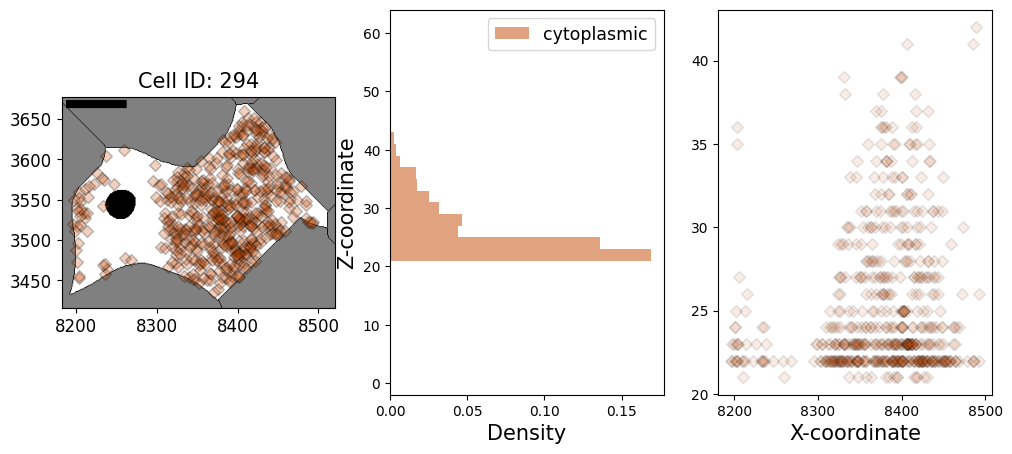

In [165]:
hparams = {'bins':np.arange(zmin, zmax+1, Ns[1]), 'alpha':0.5, 'density':True, 'orientation':'horizontal', 'zorder':2}

i = 293

NX,NY,NZ = [],[],[]

cidx = metacell.iloc[i].name
cell, cextent = utils.get_cell_img(cidx, metacell, wall, label, pxbar=False)
cell[pxbar] = 0

s_= np.s_[cextent[2]:cextent[3], cextent[0]:cextent[1]]

Nx,Ny,Nz = nuct.loc[label[ nuct['Y'], nuct['X'] ] == cidx, ['X','Y','Z']].values.T
cx,cy,cz = cytt.loc[label[ cytt['Y'], cytt['X'] ] == cidx, ['X','Y','Z']].values.T
#rng.shuffle(cz)

for k in range(len(cell_nucs[i][0])):
    nx,ny,nz = nuct.loc[label[ nuct['Y'], nuct['X'] ] == cidx].loc[lnuc[ Ny, Nx ] == cell_nucs[i][0,k], ['X','Y','Z']].values.T
    NX.append(nx); NY.append(ny); NZ.append(nz); 

fig, ax = plt.subplots( 1, 3, figsize=(12, 5), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); j = 0

ax[j].imshow(cell, cmap='binary_r', origin='lower', extent=cextent, vmin=0, vmax=2, zorder=1);
ax[j].scatter(cx,cy, c=color[0], marker=marker[0], edgecolor='k', alpha=0.25, zorder=2)    
ax[j].set_facecolor('#808080')
ax[j].tick_params(labelsize=fs-3)#ax[j].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
ax[j].set_title('Cell ID: {}'.format(metacell.loc[cidx, 'orig_cellID']), fontsize=fs)

j = 1
ax[j].hist(cz, color=color[0], label='cytoplasmic', **hparams)
for k in range(len(NZ)):
    if len(NZ[k]) > 4:
        df = cell_nuc.loc[(cell_nuc['ndimage_ID'] == cidx) & (cell_nuc['nuc_ID'] == cell_nucs[i][0,k])].iloc[0]
        n_bot, n_top, p_bot, p_top = df.loc[['n_bot', 'n_top', 'p_bot', 'p_top']].values
        dbscan = cluster.DBSCAN(eps=2.5, min_samples=5, n_jobs=1).fit_predict(NZ[k].reshape(-1,1))
        uq = np.unique(dbscan)
        for ii in uq[uq > -1]:
            nx = NX[k][dbscan == ii]; ny = NY[k][dbscan == ii]; nz = NZ[k][dbscan == ii]
            ax[0].scatter(nx, ny, c=color[k + ii+1], marker=marker[k+ii], edgecolor='yellow', alpha=0.8, zorder=3, linewidth=0.5)
            ax[1].hist(nz, color=color[k + ii+1], label='nuclear*$_{}$'.format(ii+1), **hparams)
            ax[2].scatter(nx, nz, c=color[k + ii+1], marker=marker[k+ii], 
                          edgecolor='yellow', alpha=1, zorder=3, linewidth=0.5)

        if p_top > 0:
            ll = 'KS [pval $< 10^{{{}}}$]'.format(int(np.ceil(np.log10(p_top))))
        else:
            ll = 'KS [pval = 0]'
        ax[j].axhline(n_top, c=color[k+2], ls='--', lw=3, zorder=3, label=ll)
        ax[2].axhline(n_top, c=color[k+2], ls='--', lw=3, zorder=5)
        
        if p_bot > 0:
            ll = 'KS [pval $< 10^{{{}}}$]'.format(int(np.ceil(np.log10(p_bot))))
        else:
            ll = 'KS [pval = 0]'
        ax[j].axhline(n_bot, c=color[k+1], ls='--', lw=3, zorder=3, label=ll)
        ax[2].axhline(n_bot, c=color[k+1], ls='--', lw=3, zorder=5)
        
h, l = ax[j].get_legend_handles_labels()
ax[j].legend(h[-2:], l[-2:], fontsize=12.5, loc='upper right', ncols=1);
ax[j].set_xlabel('Density', fontsize=fs)
ax[j].set_ylabel('Z-coordinate', fontsize=fs)

j += 1
ax[j].scatter(cx, cz, c=color[0], marker=marker[0], edgecolor='k', alpha=0.1, zorder=2)
ax[j].set_xlabel('X-coordinate', fontsize=fs)
if n_bot < n_top:
    ax[j].fill_between([nx.min(),nx.max()], n_top, n_bot, color='gray', alpha=0.98, zorder=4, label='hypothesized nucleus')
else:
    ax[j].fill_between([nx.min(),nx.max()], zmin , n_top, color='gray', alpha=0.98, zorder=4, label='hypothesized nucleus')
    ax[j].fill_between([nx.min(),nx.max()], zmax , n_bot, color='gray', alpha=0.98, zorder=4)
    
ax[j].legend(fontsize=12.5, loc='upper right')
for j in [1,2]:
    ax[j].set_ylim(zmin,zmax)
    ax[j].set_facecolor('snow')
    ax[j].tick_params(labelsize=fs-3)
    ax[j].set_title('Bacterial transcripts', fontsize=fs)
    
fig.legend(h[:-2], l[:-2], fontsize=12.5, loc='lower left', ncols=3, bbox_to_anchor=(0.025 , 0));
fig.tight_layout();

filename = dst + 'cell_nucleus_{}.jpg'.format(metacell.loc[cidx, 'orig_cellID'])
plt.savefig(filename, bbox_inches='tight', dpi=100)

In [166]:
i = 0
cidx, nidx = cell_nuc.iloc[i, :2].values
print(cell_nuc.iloc[i, 4] < cell_nuc.iloc[i, 5])
cell_nuc.iloc[i]

True


ndimage_ID      1.000000
nuc_ID          1.000000
perc_inside     0.011579
N_inside        0.000000
n_bot           1.000000
n_top          61.000000
p_bot           2.000000
p_top           2.000000
Name: 0, dtype: float64

In [220]:
cell_nuc.tail()

,ndimage_ID,nuc_ID,perc_inside,N_inside,n_bot,n_top,p_bot,p_top
2060,2884,1355,1.000000,0,1,61,2.0,2.0
2061,2884,1359,1.000000,0,1,61,2.0,2.0
2062,2903,1362,0.573991,0,1,61,2.0,2.0
2063,2917,1363,1.000000,0,1,61,2.0,2.0
2064,2919,1364,1.000000,0,1,61,2.0,2.0


In [227]:
tidx = 85
nuct = translocs[tidx].loc[ nuclei[ translocs[tidx]['Y'], translocs[tidx]['X'] ] ]

for i in range(len(cell_nuc)):
    cidx, nidx = cell_nuc.iloc[i, :2].values.astype(int)
    if len(nuct.loc[ (label[ nuct['Y'], nuct['X'] ] == cidx) & (lnuc[ nuct['Y'], nuct['X'] ] == nidx) ]) > 0:
        if cell_nuc.iloc[i]['N_inside'] < 2:
            print(i, cidx, nidx)

121 150 89
162 192 89
236 284 140
246 294 147
254 303 163
282 339 170
283 339 191
290 344 203
312 367 230
321 377 221
324 382 218
329 389 220
330 390 203
344 415 228
350 421 239
384 451 261
385 455 269
394 466 261
411 489 279
412 489 291
420 501 285
441 525 312
444 529 308
453 554 328
468 577 350
478 596 337
479 597 367
484 603 354
489 614 347
505 636 363
511 644 381
517 650 374
518 652 374
520 660 377
530 677 398
546 694 399
564 735 419
597 780 435
624 815 466
634 835 470
636 839 469
639 841 518
651 853 491
652 854 490
653 855 491
656 859 514
662 878 484
666 885 497
693 928 514
725 981 538
740 999 565
770 1036 551
793 1079 588
808 1108 614
812 1120 616
816 1124 618
820 1132 612
828 1144 623
837 1160 637
843 1173 659
852 1198 648
876 1241 666
906 1289 695
912 1301 701
920 1311 710
921 1313 706
924 1316 720
931 1326 709
937 1333 730
939 1340 709
951 1369 753
960 1382 730
964 1383 766
967 1387 735
975 1396 736
976 1405 742
994 1434 751
995 1435 771
1012 1457 771
1033 1500 793
1063 1545 8

In [235]:
i = 1503
cidx, nidx = cell_nuc.iloc[i][ ['ndimage_ID','nuc_ID']].values.astype(int)

In [236]:
tnc = nuct.loc[ (label[ nuct['Y'], nuct['X'] ] == cidx) & (lnuc[ nuct['Y'], nuct['X'] ] == nidx) ]
nz = tnc['Z'].values
print(nz[:20])

print(N_bot[i] < N_top[i])
tnc

[39]
False


,X,Y,Z,L
3302447,10425,12839,39,n


In [219]:
for tidx in range(10, len(transcriptomes)):
    # Fix a gene
    # Get the transcripts that are in X,Y nuclear coordinates
    
    nuct = translocs[tidx].loc[ nuclei[ translocs[tidx]['Y'], translocs[tidx]['X'] ] ]
    
    for i in range(len(cell_nuc)):
        
        cidx, nidx, n_bot, n_top = cell_nuc.iloc[i][ ['ndimage_ID', 'nuc_ID', 'n_bot', 'n_top']].values.astype(int)

        # Get the transcripts specific for a cell and nucleus
        tnc = nuct.loc[ (label[ nuct['Y'], nuct['X'] ] == cidx) & (lnuc[ nuct['Y'], nuct['X'] ] == nidx) ]
        nz = tnc['Z'].values

        if n_bot < n_top :
            localization = np.where( (nz >= n_bot) & (nz <= n_top), 'n', 'c' )
        else:
            localization = np.where( (nz >= n_top) & (nz <= n_bot), 'c', 'n' )
        
        translocs[tidx].loc[tnc.index, 'L'] = localization

In [240]:
TT = np.array([ len(translocs[tidx]) for tidx in range(10, len(transcriptomes)) ] )
NN = np.array([ len(translocs[tidx][translocs[tidx]['L'] == 'n']) for tidx in range(10,len(transcriptomes)) ])
NN

array([  197,    51,    87,    28,   118,    18,  1265,    17,     3,
           1,    32,     0,    14,     9,    85,   783,  9751,   205,
         790,   230,    22,   192,    18,    44,   838,   666,     0,
           0,    19,    15,    21,    50,     9,   160,     3,     0,
           0,   382,   457,     9,    42,     8,    27,    49,    22,
          22,   302,   903,   144,   106,     5,     1,  1820,     1,
           0,     3,   190,     4,     0,    20,    37,    19,     3,
           2,  1203,   306,     2,  1850,   172,   131,    11,     0,
          24,     9,   147, 50980,    24,     0,   154,    44,     1,
          15,   459,     4,   717,   183,    71])

In [238]:
np.argsort(TT)[::-1]+10

array([85, 26, 62, 77, 57, 28, 84, 25, 74, 16, 27, 30, 47, 31, 22, 10, 24,
       79, 56, 34, 94, 58, 48, 95, 88, 75, 90, 35, 92, 73, 91, 66, 43, 29,
       89, 71, 86, 41, 54, 67, 78, 15, 53, 11, 83, 14, 55, 13, 12, 96, 49,
       80, 59, 20, 50, 32, 70, 82, 40, 69, 33, 39, 38, 23, 87, 93, 65, 42,
       17, 76, 19, 44, 52, 61, 18, 72, 51, 46, 45, 68, 60, 21, 81, 36, 64,
       63, 37])

In [242]:
for tidx in range(len(transcriptomes)):
    filename = dst + transcriptomes[tidx] + '.txt'
    foo = translocs[tidx].copy()
    #foo['ID'] = transcriptomes[tidx]
    foo.to_csv(filename, sep='\t', index=False)

In [220]:
transcriptomes[85]

'GLYMA_17G195900'

In [218]:
filename = csrc + sample + '_data/32771-slide1_' + sample + '_results.txt'
tlocs = pd.read_csv(filename, header=None, sep='\t').drop(columns=[4])
tlocs.columns = ['X', 'Y', 'Z', 'T']

transcriptomes, invidx, tsize = np.unique(tlocs.loc[:,'T'], return_index = False, return_inverse=True, return_counts=True) 
tlocs = tlocs.loc[:, ['X','Y','Z']]
tlocs['L'] = 'c'
print('\nFound data for', len(transcriptomes), 'transcriptomes')

translocs = [None for i in range(len(transcriptomes))]
for tidx in range(len(transcriptomes)):
    translocs[tidx] = tlocs.loc[invidx == tidx]


Found data for 97 transcriptomes


# Deal with transcripts on the edge